In [41]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
import glob
import os

In [3]:
data_path="/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/wrapped_trajs_for_actin"
n_frames = 191
n_restarts = 4

In [4]:
trajData = []
colvar_data = []

for i in range(n_frames):
    for j in range(n_restarts):
        traj_file = data_path+"/frame{}/{}/frame{}_{}_positions.npy".format(i,j+1,i,j+1)
        colvar_file = data_path+"/frame{}/{}/frame{}_{}_colvar.txt".format(i,j+1,i,j+1)
        
        traj = np.load(traj_file, allow_pickle=True)
        colvar = np.loadtxt(colvar_file)
        
        trajData.append(traj)
        colvar_data.append(colvar)

trajData = np.concatenate(trajData, axis=0)
colvar_data = np.concatenate(colvar_data, axis=0)

print(trajData.shape)
print(colvar_data.shape)

(153564, 375, 3)
(153564, 4)


In [5]:
kt = 0.616033   # @T=310K in kcal/molK unit
ld1 = colvar_data[:,0]
cleft_dist = colvar_data[:,1]*10.0
dihedral = colvar_data[:,2]*180.0/3.14
opes_bias = colvar_data[:,3]+15.0  # adding the barrier value to bias 
weights = np.exp(opes_bias/kt)
weights /=  np.sum(weights)

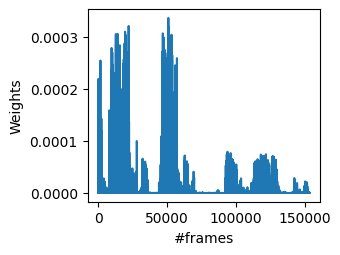

In [6]:
plt.figure(figsize=(3,2.5))
plt.xlabel("#frames")
plt.ylabel("Weights")
plt.plot(weights)

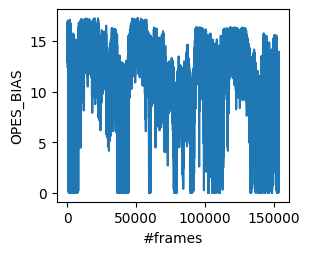

In [7]:
plt.figure(figsize=(3,2.5))
plt.xlabel("#frames")
plt.ylabel("OPES_BIAS")
plt.plot(opes_bias)

## Run the cluster scan ->

In [8]:
# define cluster array 
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


In [11]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 138208, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 138208
Number of frames to predict each model: 15356
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1            1010.288          30.572
              1               2               1            1056.006          30.428
              1               2               2            1048.498          42.069
              1               2               3            1054.530          38.532
              1               2               4            1058.407          32.827
              1               2               5            1045.057          29.645
              1               2               6            1055.693          27.712
              1               2               7            1044.

              2               6               3            1111.147          78.686
              2               6               4            1114.430          58.309
              2               6               5            1129.565          68.404
              2               6               6            1119.280          78.062
              2               6               7            1131.530          66.221
              2               6               8            1124.039          74.526
              2               6               9            1107.695          51.052
              2               6              10            1104.876          70.382
              3               1               1            1010.813          29.859
              3               2               1            1023.425          39.703
              3               2               2            1065.350          31.106
              3               2               3            1041.897         

              4               5               9            1125.643          51.655
              4               5              10            1092.463          57.095
              4               6               1            1119.743          55.086
              4               6               2            1117.067          48.624
              4               6               3            1102.559          53.051
              4               6               4            1105.832          45.413
              4               6               5            1107.987          53.456
              4               6               6            1144.714          53.585
              4               6               7            1099.752          59.204
              4               6               8            1082.827          45.505
              4               6               9            1091.927          52.162
              4               6              10            1077.614         

In [8]:
train = np.loadtxt("train_all_data.dat")[:,1:]
cv = np.loadtxt("cv_all_data.dat")[:,1:]

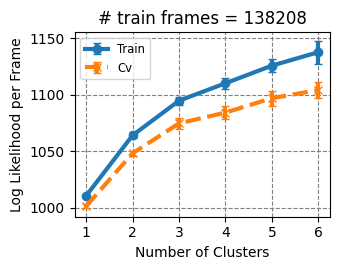

In [9]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 100, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Train")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cv")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')

plt.ylabel("Log Likelihood per Frame")
plt.title("# train frames = 138208")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(fontsize="small")
plt.tight_layout()

## 3 Clusters 

In [15]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 153564
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1074.429          54.756
       2            1089.512          36.504
       3            1068.275          40.669
       4            1075.853          41.205
       5            1075.141          40.824
       6            1070.958          56.538
       7            1070.523          49.640
       8            1072.577          49.464
       9            1084.012          58.934
      10            1093.090          37.114
      11            1085.591          51.261
      12            1079.316          52.559
      13            1081.408          54.233
      14            1067.626          52.071
      15            1060.959          40.358
      16            1068.244          40.778
      17            1068.986          44.116
      18            1081.934          39.484
      19       

In [9]:
with open("wsgmm_3state_all_data.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

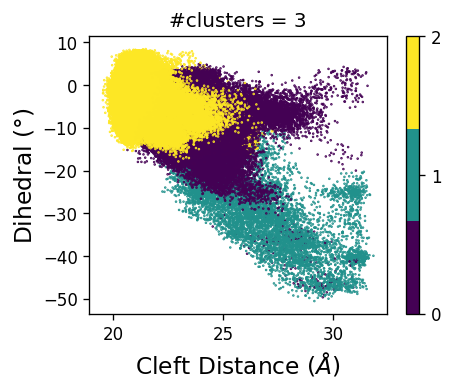

In [13]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 3")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist, dihedral, c=wsgmm3.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

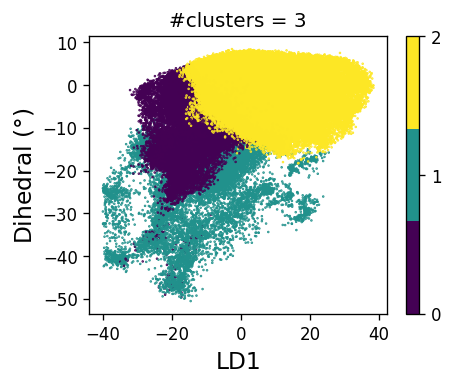

In [14]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 3")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1, dihedral, c=wsgmm3.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

34016
17091
102457


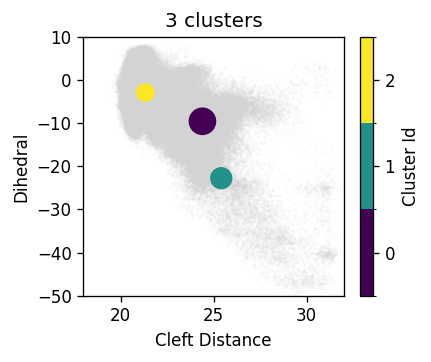

In [15]:
cluster_indx = []
for i in range(wsgmm3.n_clusters):
    indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    cluster_indx.append(indx)
    print(len(indx))
    
avg_dihedral = [np.mean(dihedral[cluster_indx[i]]) for i in range(wsgmm3.n_clusters)]
avg_cleft_dist = [np.mean(cleft_dist[cluster_indx[i]]) for i in range(wsgmm3.n_clusters)]

from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm3.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm3.n_clusters+1), cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.title("3 clusters")
plt.xlabel("Cleft Distance")
plt.ylabel("Dihedral")
plt.xlim(18,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist, dihedral, marker='.', s=0.01, color="lightgray")
plt.scatter(avg_cleft_dist, avg_dihedral, marker='o', c=np.arange(wsgmm3.n_clusters), s=wsgmm3.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm3.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm3.n_clusters))
cbar.set_label("Cluster Id")

## 4 Clusters

In [21]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 153564
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1071.985          51.655
       2            1099.718          56.606
       3            1110.389          55.237
       4            1067.336          47.788
       5            1104.568          60.509
       6            1094.228          48.347
       7            1116.495          40.737
       8            1101.522          66.475
       9            1081.169          54.397
      10            1086.452          57.240
      11            1073.060          41.353
      12            1112.195          52.914
      13            1073.141          44.668
      14            1085.361          64.092
      15            1090.614          52.620
      16            1098.094          49.306
      17            1075.401          44.382
      18            1113.734          48.354
      19       

In [10]:
with open("wsgmm_4state_all_data.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

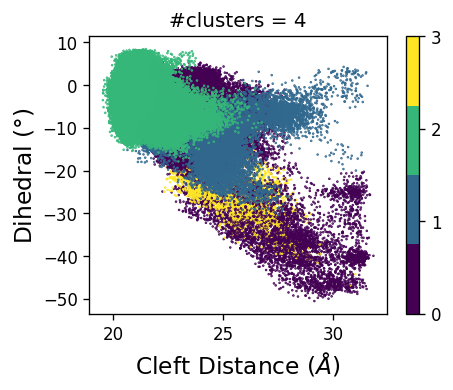

In [24]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 4")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist, dihedral, c=wsgmm4.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

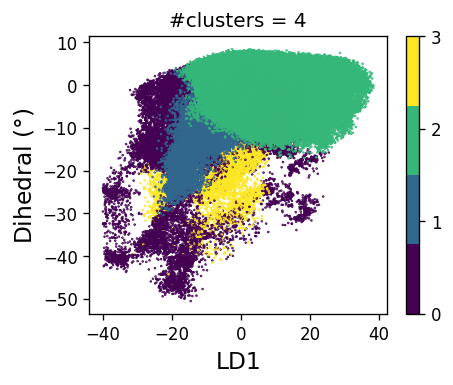

In [25]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 4")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1, dihedral, c=wsgmm4.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

40230
12102
94026
7206


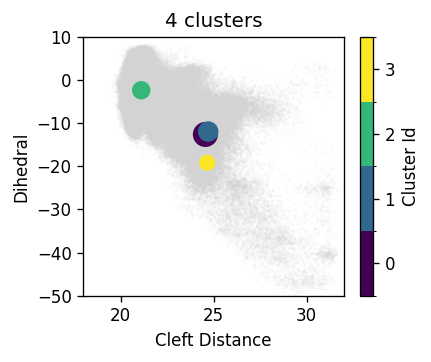

In [26]:
cluster_indx = []
for i in range(wsgmm4.n_clusters):
    indx = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]
    cluster_indx.append(indx)
    print(len(indx))
    
avg_dihedral = [np.mean(dihedral[cluster_indx[i]]) for i in range(wsgmm4.n_clusters)]
avg_cleft_dist = [np.mean(cleft_dist[cluster_indx[i]]) for i in range(wsgmm4.n_clusters)]

from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm4.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm4.n_clusters+1), cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.title("4 clusters")
plt.xlabel("Cleft Distance")
plt.ylabel("Dihedral")
plt.xlim(18,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist, dihedral, marker='.', s=0.01, color="lightgray")
plt.scatter(avg_cleft_dist, avg_dihedral, marker='o', c=np.arange(wsgmm4.n_clusters), s=wsgmm4.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm4.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm4.n_clusters))
cbar.set_label("Cluster Id")

## 5 Clusters -->

In [27]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 153564
Number of clusters: 5
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1107.774          56.271
       2            1080.431          51.905
       3            1099.291          57.475
       4            1117.449          56.361
       5            1079.490          53.637
       6            1084.543          50.278
       7            1117.151          51.264
       8            1119.365          55.404
       9            1110.121          63.405
      10            1114.805          46.762
      11            1092.306          62.324
      12            1113.398          55.140
      13            1109.857          44.487
      14            1097.564          52.478
      15            1092.558          52.581
      16            1094.427          58.039
      17            1083.605          62.326
      18            1121.640          67.107
      19       

In [11]:
with open("wsgmm_5state_all_data.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

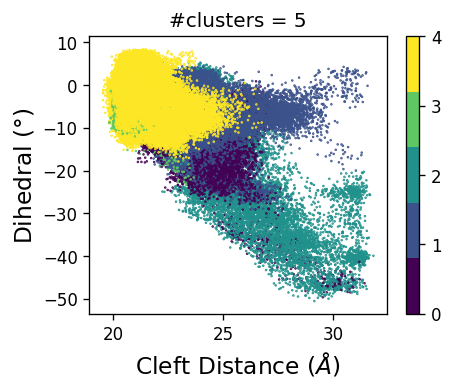

In [30]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist, dihedral, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

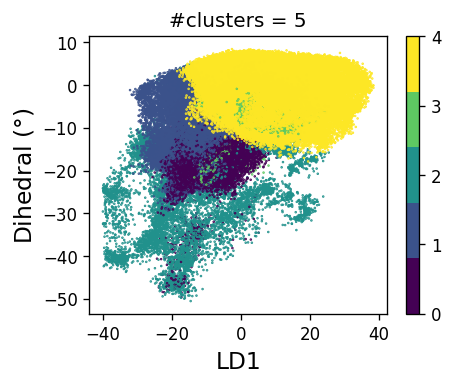

In [31]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1, dihedral, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

20313
16251
21150
9139
86711


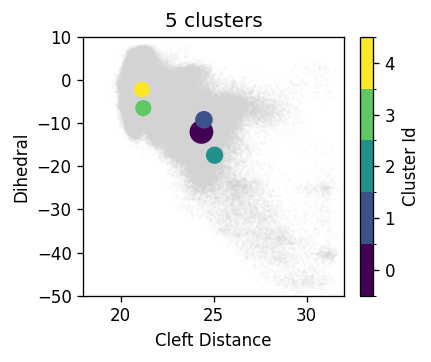

In [32]:
cluster_indx = []
for i in range(wsgmm5.n_clusters):
    indx = [x[0] for x in np.argwhere(wsgmm5.cluster_ids == i)]
    cluster_indx.append(indx)
    print(len(indx))

avg_dihedral = [np.mean(dihedral[cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]
avg_cleft_dist = [np.mean(cleft_dist[cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]

from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.title("5 clusters")
plt.xlabel("Cleft Distance")
plt.ylabel("Dihedral")
plt.xlim(18,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist, dihedral, marker='.', s=0.01, color="lightgray")
plt.scatter(avg_cleft_dist, avg_dihedral, marker='o', c=np.arange(wsgmm5.n_clusters), s=wsgmm5.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm5.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar.set_label("Cluster Id")

## 6 Clusters 

In [33]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 6, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 153564
Number of clusters: 6
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1111.980          61.960
       2            1124.548          54.046
       3            1113.972          53.788
       4            1106.550          74.938
       5            1140.453          60.820
       6            1104.081          62.759
       7            1110.196          62.035
       8            1119.939          67.732
       9            1129.602          78.113
      10            1110.599          66.295
      11            1120.000          86.224
      12            1133.432          66.169
      13            1114.502          68.780
      14            1093.787          73.832
      15            1117.160          72.290
      16            1087.077          83.358
      17            1105.748          67.696
      18            1125.984          66.318
      19       

In [12]:
with open("wsgmm_6state_all_data.pickle", "rb") as f:
    wsgmm6 = pickle.load(f)

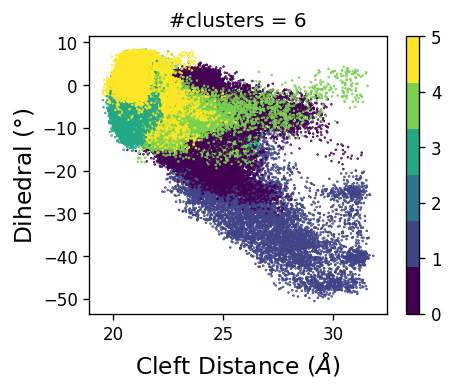

In [36]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 6")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist, dihedral, c=wsgmm6.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

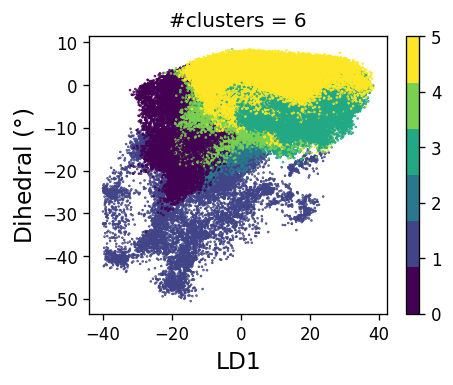

In [37]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 6")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1, dihedral, c=wsgmm6.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

19157
14070
6432
44636
23650
45619


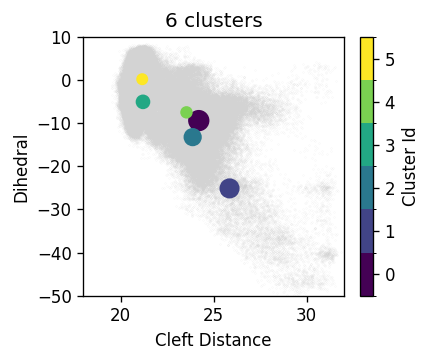

In [38]:
cluster_indx = []
for i in range(wsgmm6.n_clusters):
    indx = [x[0] for x in np.argwhere(wsgmm6.cluster_ids == i)]
    cluster_indx.append(indx)
    print(len(indx))
    
avg_dihedral = [np.mean(dihedral[cluster_indx[i]]) for i in range(wsgmm6.n_clusters)]
avg_cleft_dist = [np.mean(cleft_dist[cluster_indx[i]]) for i in range(wsgmm6.n_clusters)]

from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm6.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm6.n_clusters+1), cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.title("6 clusters")
plt.xlabel("Cleft Distance")
plt.ylabel("Dihedral")
plt.xlim(18,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist, dihedral, marker='.', s=0.01, color="lightgray")
plt.scatter(avg_cleft_dist, avg_dihedral, marker='o', c=np.arange(wsgmm6.n_clusters), s=wsgmm6.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm6.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm6.n_clusters))
cbar.set_label("Cluster Id")

In [44]:
def sort_files(item):
    x1 = int(item.split("/")[-3][5::])
    x2 = int(item.split("/")[-2])
    return x1,x2

def sort_pdb(item):
    x = int(item.split(".")[0].split("_")[-1])
    return x 

In [56]:
loc_traj_files = "/scratch/projects/hockygroup/gmh4/projects/gmm_clustering/weighted_gmm/actin_clustering_generate_frames/prod_continue_310K/every5ps_trr"
trr_files = glob.glob(loc_traj_files+"/frame*/*/*.trr")
trr_files_sorted = np.array(sorted(trr_files, key=sort_files))
print(len(trr_files_sorted))
#c = 0
#for file in trr_files_sorted:
#    print(c, "/".join(file.split("/")[-3::]))
#    c += 1

764


(764,)


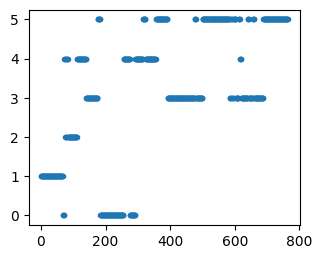

In [57]:
traj_first_frame_labels = wsgmm6.cluster_ids[::201]
print(traj_first_frame_labels.shape)

plt.figure(figsize=(3.5,2.8))
plt.plot(traj_first_frame_labels, '.')

In [58]:
loc_list = []
for i in range(wsgmm6.n_clusters):
    loc = [x[0] for x in np.argwhere(traj_first_frame_labels == i)]
    print(len(loc))
    loc_list.append(loc)

92
68
32
216
116
240


In [37]:
print(loc_list[0])

[ 68  69  70  71 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291]


In [18]:
def pseudo_inv(mat,remove):
    # it calculates the pseudo inverse of a singular matrix
    e, v = np.linalg.eigh(mat)
    e[remove:] = 1/e[remove:]
    e[:remove] = 0.00
    return np.dot(v,np.dot(np.diag(e),v.T))

(6, 375)


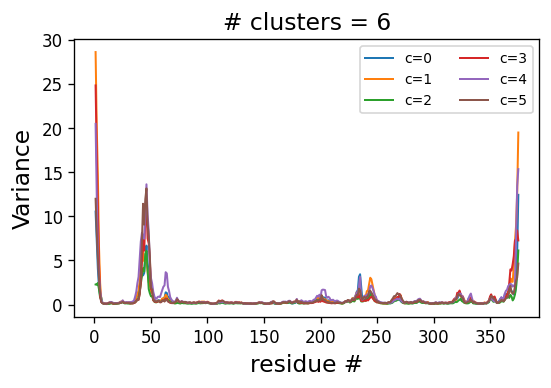

In [14]:
vars_ = np.empty((wsgmm6.n_clusters, trajData.shape[1]))
for i in range(wsgmm6.n_clusters):
    #vars_[i,:] = np.diag(np.linalg.pinv(wsgmm6.precisions[i]))
    vars_[i,:] = np.diag(pseudo_inv(wsgmm6.precisions[i], 1))
print(vars_.shape)

plt.figure(figsize=(5,3), dpi=120)
plt.xlabel("residue #", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("# clusters = 6", fontsize=14)
for i in range(wsgmm6.n_clusters):
    plt.plot(np.arange(1,376), vars_[i,:], label="c=%d"%i, ls="-", lw=1.2)
plt.legend(ncol=2, fontsize='small')

#plt.plot(np.arange(1,376), vars_[3,:], label="c=3", ls="-", lw=1.2)
#plt.plot(np.arange(1,376), vars_[5,:], label="c=5", ls="-", lw=1.2)

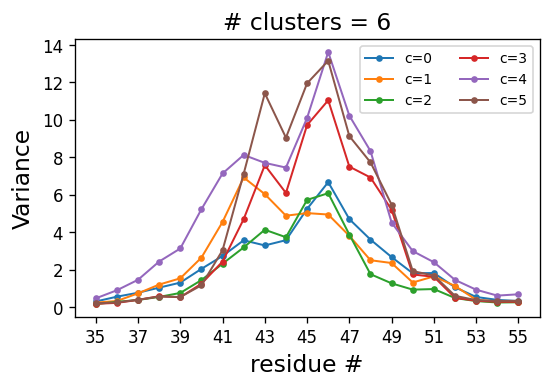

In [15]:
plt.figure(figsize=(5,3), dpi=120)
plt.xlabel("residue #", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("# clusters = 6", fontsize=14)
#plt.ylim(0,50)
plt.xticks(np.arange(35,56,2))
for i in range(wsgmm6.n_clusters):
    plt.plot(np.arange(35,56), vars_[i,34:55:1], '.-', label="c=%d"%i, lw=1.2)
plt.legend(ncol=2, fontsize='small')

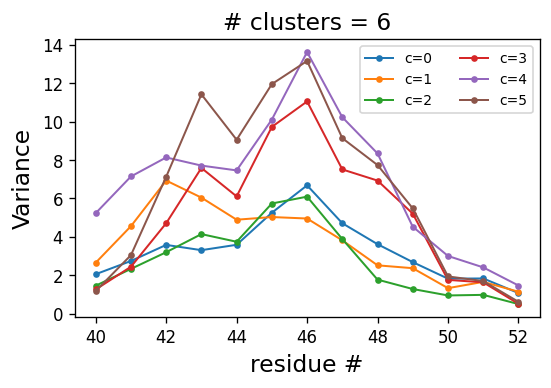

In [16]:
plt.figure(figsize=(5,3), dpi=120)
plt.xlabel("residue #", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("# clusters = 6", fontsize=14)
#plt.ylim(0,50)
plt.xticks(np.arange(40,53,2))
for i in range(wsgmm6.n_clusters):
    plt.plot(np.arange(40,53), vars_[i,39:52:1], '.-', label="c=%d"%i, lw=1.2)
plt.legend(ncol=2, fontsize='small')

## check the RMSF fluctuations for 5 clusters

(5, 375)


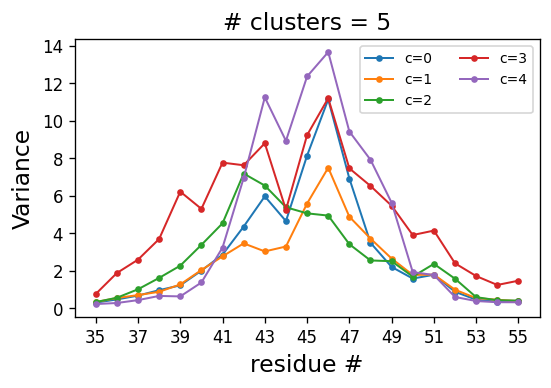

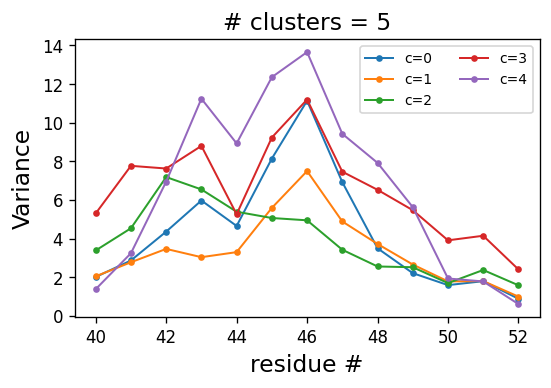

In [19]:
vars_ = np.empty((wsgmm5.n_clusters, trajData.shape[1]))
for i in range(wsgmm5.n_clusters):
    #vars_[i,:] = np.diag(np.linalg.pinv(wsgmm5.precisions[i]))
    vars_[i,:] = np.diag(pseudo_inv(wsgmm5.precisions[i], 1))
print(vars_.shape)

plt.figure(figsize=(5,3), dpi=120)
plt.xlabel("residue #", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("# clusters = 5", fontsize=14)
#plt.ylim(0,50)
plt.xticks(np.arange(35,56,2))
for i in range(wsgmm5.n_clusters):
    plt.plot(np.arange(35,56), vars_[i,34:55:1], '.-', label="c=%d"%i, lw=1.2)
plt.legend(ncol=2, fontsize='small')

plt.figure(figsize=(5,3), dpi=120)
plt.xlabel("residue #", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("# clusters = 5", fontsize=14)
#plt.ylim(0,50)
plt.xticks(np.arange(40,53,2))
for i in range(wsgmm5.n_clusters):
    plt.plot(np.arange(40,53), vars_[i,39:52:1], '.-', label="c=%d"%i, lw=1.2)
plt.legend(ncol=2, fontsize='small')

## let's extract the files for 5 clusters ->

(764,)
92
84
108
48
432


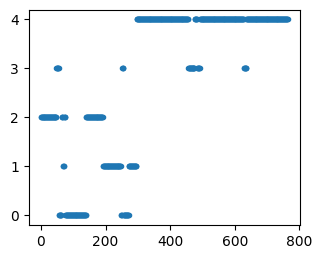

In [45]:
traj_first_frame_labels = wsgmm5.cluster_ids[::201]
print(traj_first_frame_labels.shape)

plt.figure(figsize=(3.5,2.8))
plt.plot(traj_first_frame_labels, '.')

loc_list = []
for i in range(wsgmm5.n_clusters):
    loc = [x[0] for x in np.argwhere(traj_first_frame_labels == i)]
    print(len(loc))
    loc_list.append(loc)

pdb_files_sorted = np.array(sorted(glob.glob("first_frame_pdb_files/*.pdb"), key=sort_pdb))

for i in range(wsgmm5.n_clusters):
    files = pdb_files_sorted[loc_list[i]]
    dir_ = "c%d_files_5clusters"%i
    if not os.path.isfile(dir_):
        os.mkdir(dir_)
        for file in files:
            os.system("cp "+file+" "+dir_)
    else:
        raise(dir_+" already exists! Please check.")

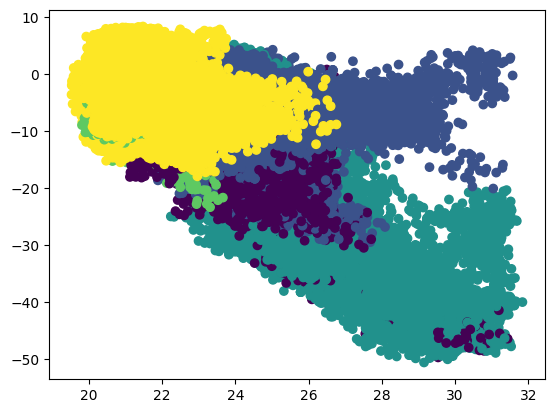

In [42]:
plt.scatter(cleft_dist, dihedral, c=wsgmm5.cluster_ids)